# Objective
* 20181230: 
    * Predict stock price in next day using simple moving average
    * Given prices for the last N days, we do prediction for day N+1
* 20190121 - Diff from StockPricePrediction_v3_mov_avg.ipynb:
    * Here we use last value to do prediction

In [0]:
%matplotlib inline

import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

#### Input params ##################
#stk_path = "https://raw.githubusercontent.com/decoderkurt/Deep_Valuation/master/deep_valuation/deep_valuation/train_vertical.csv?token=ABW4VEWU4TOHOLKINUL6U225EMN36"
stk_path = "https://raw.githubusercontent.com/decoderkurt/Deep_Valuation/master/deep_valuation/deep_valuation/1.csv?token=ABW4VERLLKKURUVBBNPMSPS5EMORS"
test_size = 0.2                 # proportion of dataset to be used as test set
cv_size = 0.2                   # proportion of dataset to be used as cross-validation set
Nmax = 2                       # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N we are going to test
fontsize = 14
ticklabelsize = 14
####################################

# Common functions

In [0]:
def get_preds_mov_avg(df, target_col, N, pred_min, offset):
    """
    Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Using simple moving average.
    Inputs
        df         : dataframe with the values you want to predict. Can be of any length.
        target_col : name of the column you want to predict e.g. 'adj_close'
        N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
        pred_min   : all predictions should be >= pred_min
        offset     : for df we only do predictions for df[offset:]. e.g. offset can be size of training set
    Outputs
        pred_list  : list. The predictions for target_col. np.array of length len(df)-offset.
    """
    pred_list = df[target_col].rolling(window = N, min_periods=1).mean() # len(pred_list) = len(df)
    
    # Add one timestep to the predictions
    pred_list = np.concatenate((np.array([np.nan]), np.array(pred_list[:-1])))
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
    
    return pred_list[offset:]

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Load data

In [4]:
df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'date'] = pd.to_datetime(df['date'],format='%Y%m%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# # Get month of each sample
# df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

,date,volumn,close
0,1992-08-28,160000,500
1,1994-11-05,80000,500
2,1996-06-21,200000,500
3,1996-12-28,40000,10000
4,1999-06-25,118100,9846
5,2000-01-06,400000,8000
6,2000-03-16,700000,40000
7,2005-07-07,650000,5150
8,2005-12-19,2000000,11000


In [5]:
df['date'].min(), df['date'].max() 

(Timestamp('1992-08-28 00:00:00'), Timestamp('2005-12-19 00:00:00'))

Text(0, 0.5, 'WON')

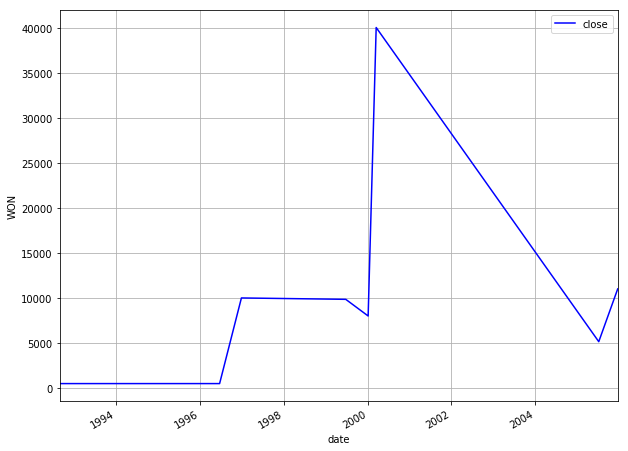

In [6]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("WON")

# Split into train, dev and test set

In [7]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 7
num_cv = 1
num_test = 1
train.shape = (7, 3)
cv.shape = (1, 3)
train_cv.shape = (8, 3)
test.shape = (1, 3)


In [8]:
test['date'].min(), test['date'].max()

(Timestamp('2005-12-19 00:00:00'), Timestamp('2005-12-19 00:00:00'))

# EDA

Text(0, 0.5, 'WON')

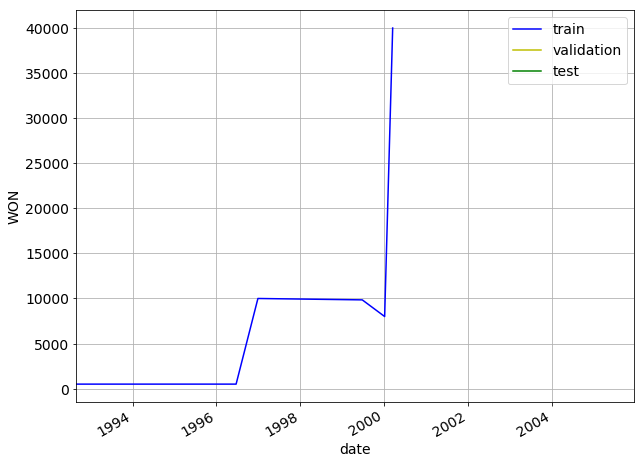

In [9]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("WON")

# Predict using Moving Average

In [10]:
RMSE = []
mape = []
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = get_preds_mov_avg(train_cv, 'close', N, 0, num_train)
    
    cv['est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['close'])))
    mape.append(get_mape(cv['close'], est_list))
print('RMSE = ' + str(RMSE))
print('MAPE = ' + str(mape))
df.head()

RMSE = [34850.0, 18850.0]
MAPE = [676.6990291262136, 366.0194174757282]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,date,volumn,close
0,1992-08-28,160000,500
1,1994-11-05,80000,500
2,1996-06-21,200000,500
3,1996-12-28,40000,10000
4,1999-06-25,118100,9846


Text(0, 0.5, 'RMSE')

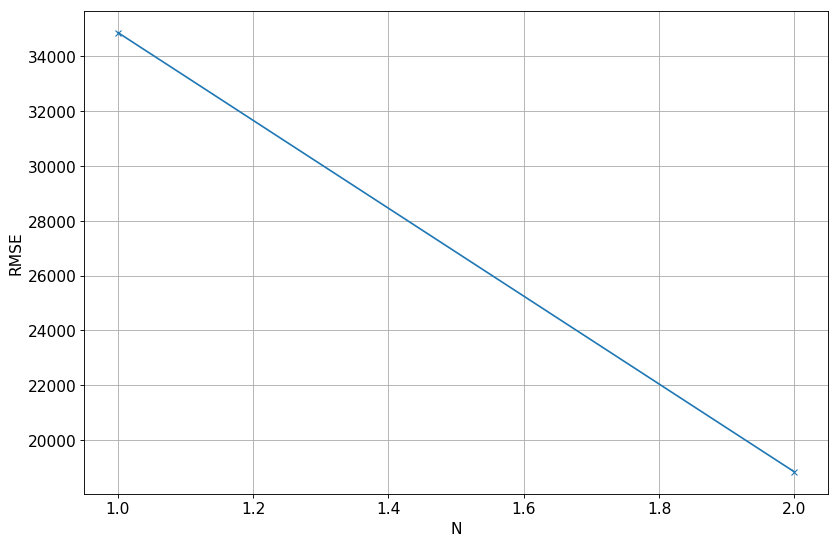

In [11]:
# Plot RMSE versus N
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')

Text(0, 0.5, 'MAPE')

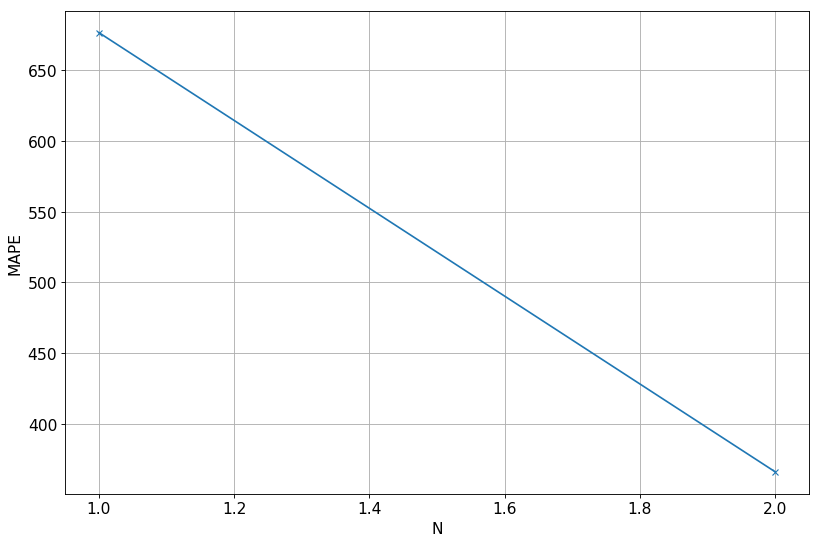

In [12]:
# Plot MAPE versus N. Note for MAPE smaller better. 
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), mape, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('MAPE')

In [0]:
# Set optimum N
N_opt = 1

# Plot Predictions on dev set

Text(0, 0.5, 'WON')

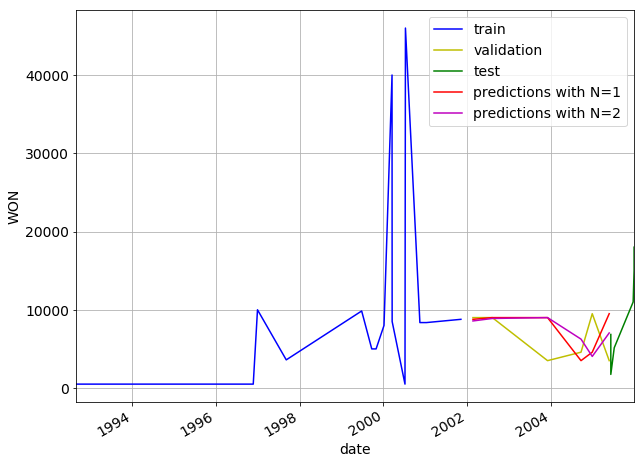

In [17]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='r-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N2', style='m-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N=1', 'predictions with N=2'])
ax.set_xlabel("date")
ax.set_ylabel("WON")

Text(0.5, 1.0, 'Zoom in to dev set')

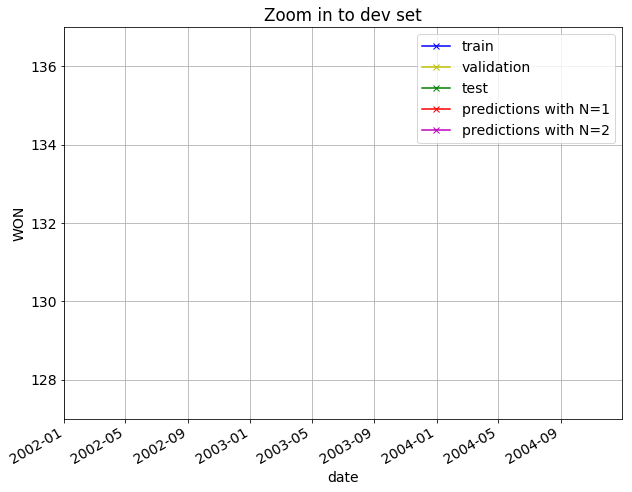

In [21]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='close', style='bx-', grid=True)
ax = cv.plot(x='date', y='close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='gx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='rx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N2', style='mx-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N=1', 'predictions with N=2'])
ax.set_xlabel("date")
ax.set_ylabel("WON")
ax.set_xlim([date(2002, 1, 1), date(2004, 12, 30)])
ax.set_ylim([127, 137])
ax.set_title('Zoom in to dev set')

# Final Model

In [22]:
est_list = get_preds_mov_avg(df, 'close', N_opt, 0, num_train+num_cv)
test['est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['close'])))
print("MAPE = %0.3f%%" % get_mape(test['close'], est_list))
test.head()

RMSE = 4244.949
MAPE = 84.175%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,date,id,volume,close,est_N1
28,2005-06-07,3,1919,6846,3500.0
27,2005-06-07,3,45296,1740,6846.0
7,2005-07-07,1,650000,5150,1740.0
8,2005-12-19,1,2000000,11000,5150.0
16,2005-12-27,2,1890000,15000,11000.0


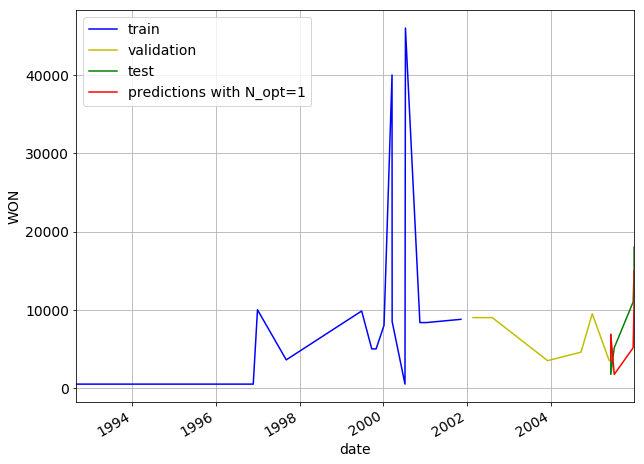

In [23]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N1', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N_opt=1'])
ax.set_xlabel("date")
ax.set_ylabel("WON")
matplotlib.rcParams.update({'font.size': 14})

Text(0.5, 1.0, 'Zoom in to test set')

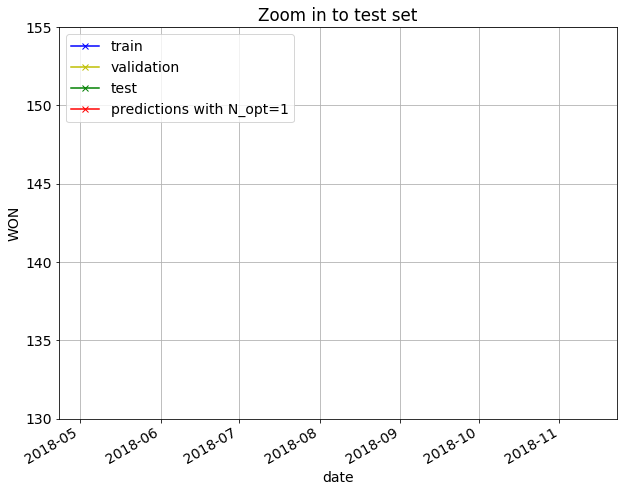

In [24]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='close', style='bx-', grid=True)
ax = cv.plot(x='date', y='close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='gx-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N1', style='rx-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N_opt=1'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("WON")
ax.set_xlim([date(2018, 4, 23), date(2018, 11, 23)])
ax.set_ylim([130, 155])
ax.set_title('Zoom in to test set')

(130, 155)

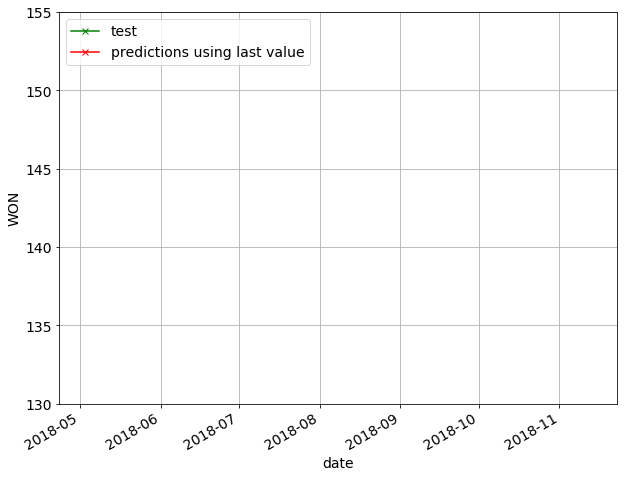

In [25]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='close', style='gx-', grid=True)
ax = test.plot(x='date', y='est_N1', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using last value'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("WON")
ax.set_xlim([date(2018, 4, 23), date(2018, 11, 23)])
ax.set_ylim([130, 155])

In [0]:
# Save as csv
test_last_value = test
test_last_value.to_csv("./out/test_last_value.csv")

# Findings
* On the test set, the RMSE is 1.127 and MAPE is 0.565% using last value prediction

In [0]:
# Compare various methods
results_dict = {'method': ['Last Value', 'Moving Average', 'Linear Regression', 'XGBoost', 'LSTM'],
                'RMSE': [1.127, 1.27, 1.42, 1.162, 1.164],
                'MAPE(%)': [0.565, 0.64, 0.707, 0.58, 0.583]}
results = pd.DataFrame(results_dict)
results

,method,RMSE,MAPE(%)
0,Last Value,1.127,0.565
1,Moving Average,1.270,0.640
2,Linear Regression,1.420,0.707
3,XGBoost,1.162,0.580
4,LSTM,1.164,0.583


In [0]:
# Read all dataframes for the different methods
test_last_value = pd.read_csv("./out/test_last_value.csv", index_col=0)
test_last_value.loc[:, 'date'] = pd.to_datetime(test_last_value['date'],format='%Y-%m-%d')

test_mov_avg = pd.read_csv("./out/test_mov_avg.csv", index_col=0)
test_mov_avg.loc[:, 'date'] = pd.to_datetime(test_mov_avg['date'],format='%Y-%m-%d')

test_lin_reg = pd.read_csv("./out/test_lin_reg.csv", index_col=0)
test_lin_reg.loc[:, 'date'] = pd.to_datetime(test_lin_reg['date'],format='%Y-%m-%d')

test_xgboost = pd.read_csv("./out/test_xgboost.csv", index_col=0)
test_xgboost.loc[:, 'date'] = pd.to_datetime(test_xgboost['date'],format='%Y-%m-%d')

test_lstm = pd.read_csv("./out/test_lstm.csv", index_col=0)
test_lstm.loc[:, 'date'] = pd.to_datetime(test_lstm['date'],format='%Y-%m-%d')

NameError: ignored

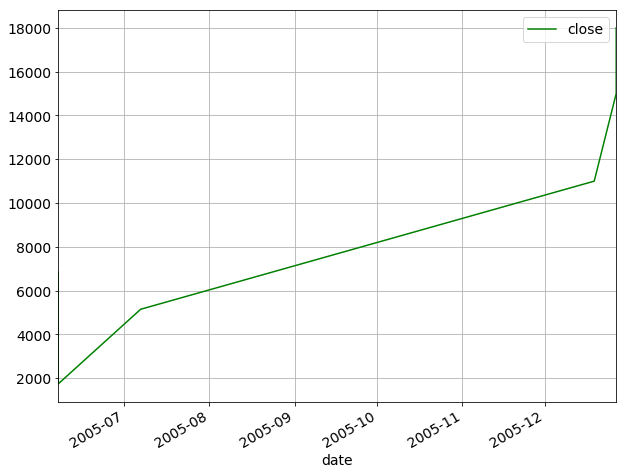

In [26]:
# Plot all methods together to compare
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='close', style='g-', grid=True)
ax = test_last_value.plot(x='date', y='est_N1', style='r-', grid=True, ax=ax)
ax = test_mov_avg.plot(x='date', y='est_N2', style='b-', grid=True, ax=ax)
ax = test_lin_reg.plot(x='date', y='est_N5', style='m-', grid=True, ax=ax)
ax = test_xgboost.plot(x='date', y='est', style='y-', grid=True, ax=ax)
ax = test_lstm.plot(x='date', y='est', style='c-', grid=True, ax=ax)
ax.legend(['test', 
           'predictions using last value', 
           'predictions using moving average', 
           'predictions using linear regression',
           'predictions using XGBoost',
           'predictions using LSTM'], loc='lower left')
ax.set_xlabel("date")
ax.set_ylabel("WON")
# ax.set_xlim([date(2018, 4, 23), date(2018, 11, 23)])
ax.set_xlim([date(2018, 7, 1), date(2018, 11, 23)])
ax.set_ylim([131, 151.5])